## Imports

In [1]:
import re
import os
import gc
import string
from collections import Counter

os.environ['XLA_FLAGS']="--xla_gpu_cuda_data_dir=/usr/lib/cuda"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download("punkt_tab", download_dir="../nltk_data/punkt_tab", quiet=False)
nltk.download("stopwords", download_dir="../nltk_data/stopwords", quiet=False)
nltk.download("wordnet", download_dir="../nltk_data/wordnet", quiet=False)

for subdir in os.scandir("../nltk_data/"):
    if subdir.is_dir():
        nltk.data.path.append(subdir.path)
        
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import keras.preprocessing as prep
from keras import layers, models, optimizers, losses, callbacks
from keras.initializers import Constant
from keras.models import Sequential
from keras.optimizers import SGD, Adam
import keras_tuner as kt


2025-01-26 12:22:28.393821: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-26 12:22:28.402776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-26 12:22:28.414379: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-26 12:22:28.417980: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 12:22:28.426750: I tensorflow/core/platform/cpu_feature_guar

In [2]:
sns.set(font_scale=1.2, palette='Set2')

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 24
plt.rcParams["figure.figsize"] = (12, 7)

SEED = 42

## Utils

Instead of pre-allocating all GPU memory, we force TensorFlow to allocate memory as needed

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs.")
    except RuntimeError as e:
        print(e)

Memory growth enabled for GPUs.


I0000 00:00:1737883364.359662   13994 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737883364.392164   13994 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737883364.395992   13994 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


## Download data

In [1]:
!curl -L -o ../data/imdb-dataset-of-50k-movie-reviews.zip\
  https://www.kaggle.com/api/v1/datasets/download/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
!unzip ../data/imdb-dataset-of-50k-movie-reviews.zip -d ../data
!rm ../data/imdb-dataset-of-50k-movie-reviews.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 25.7M  100 25.7M    0     0  2439k      0  0:00:10  0:00:10 --:--:-- 3040k
Archive:  ../data/imdb-dataset-of-50k-movie-reviews.zip
  inflating: ../data/IMDB Dataset.csv  


## EDA

In [4]:
df = pd.read_csv('../data/IMDB Dataset.csv')
print(df.shape)
df.head()

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Some text processing

In [5]:
df['review'] = df['review'].str.lower()
df['review'] = df['review'].str.replace('[^\w\s]','')
df['review'] = df['review'].str.replace('<br />','')
df['review'].head(10)

0    one of the other reviewers has mentioned that ...
1    a wonderful little production. the filming tec...
2    i thought this was a wonderful way to spend ti...
3    basically there's a family where a little boy ...
4    petter mattei's "love in the time of money" is...
5    probably my all-time favorite movie, a story o...
6    i sure would like to see a resurrection of a u...
7    this show was an amazing, fresh & innovative i...
8    encouraged by the positive comments about this...
9    if you like original gut wrenching laughter yo...
Name: review, dtype: object

Target distribution

In [10]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

The dataset is balanced, it's cool

Now let's look at most frequent words

In [11]:
cnter = Counter()

for rvw in df['review']:
    cnter.update(rvw.split())

cnter.most_common(20)

[('the', 640479),
 ('a', 316784),
 ('and', 313818),
 ('of', 286694),
 ('to', 264641),
 ('is', 204891),
 ('in', 180041),
 ('i', 142472),
 ('this', 138997),
 ('that', 130169),
 ('it', 129847),
 ('was', 93269),
 ('as', 88420),
 ('with', 84624),
 ('for', 84584),
 ('but', 78035),
 ('on', 62932),
 ('movie', 61496),
 ('are', 57013),
 ('his', 56887)]

THe nost common words are senseless. Let's vizualize them with wordcloud

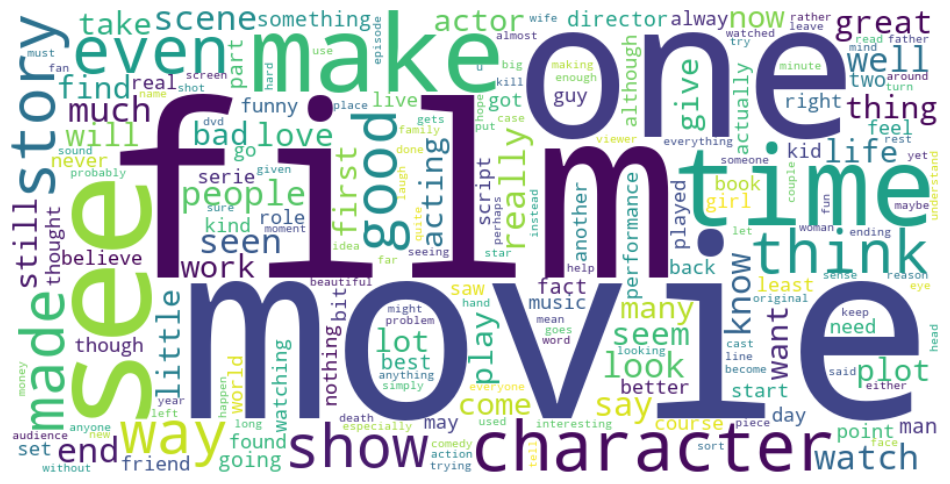

In [12]:
wc = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['review'].values))
plt.figure()
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show();

Review length distribution stratified by sentiment

In [5]:
df['review_len'] = df['review'].apply(lambda x: len(x.split()))
df.groupby('sentiment')['review_len'].describe()

,count,mean,std,min,25%,50%,75%,max
sentiment,,,,,,,,
negative,25000.0,225.30248,161.849431,4.0,126.0,171.0,273.0,1474.0
positive,25000.0,228.92728,174.455871,10.0,123.0,170.0,278.0,2450.0


The length distribution is the same

## Baseline    

We'll try tf-idf embeddings with logistic regression and catboost

In [30]:
df_copy = df.copy()

stopw = stopwords.words('english')
stopwords_pattern = r'\b(?:' + r'|'.join(re.escape(word) for word in stopw) + r')\b'
df_copy['review'] = df_copy['review'].str.replace(stopwords_pattern, '', regex=True)

tokens = [word_tokenize(review) for review in df_copy['review']]

In [32]:
tokens[:3]

[['one',
  'reviewers',
  'mentioned',
  'watching',
  '1',
  'oz',
  'episode',
  "'",
  'hooked',
  '.',
  'right',
  ',',
  'exactly',
  'happened',
  '.',
  'first',
  'thing',
  'struck',
  'oz',
  'brutality',
  'unflinching',
  'scenes',
  'violence',
  ',',
  'set',
  'right',
  'word',
  'go',
  '.',
  'trust',
  ',',
  'show',
  'faint',
  'hearted',
  'timid',
  '.',
  'show',
  'pulls',
  'punches',
  'regards',
  'drugs',
  ',',
  'sex',
  'violence',
  '.',
  'hardcore',
  ',',
  'classic',
  'use',
  'word',
  '.',
  'called',
  'oz',
  'nickname',
  'given',
  'oswald',
  'maximum',
  'security',
  'state',
  'penitentary',
  '.',
  'focuses',
  'mainly',
  'emerald',
  'city',
  ',',
  'experimental',
  'section',
  'prison',
  'cells',
  'glass',
  'fronts',
  'face',
  'inwards',
  ',',
  'privacy',
  'high',
  'agenda',
  '.',
  'em',
  'city',
  'home',
  'many',
  '..',
  'aryans',
  ',',
  'muslims',
  ',',
  'gangstas',
  ',',
  'latinos',
  ',',
  'christians',

Drop punctuation and digits

In [53]:
cleaned_tokens = []

for review_tokens in tokens:
    filtered_tokens = [
        re.sub(r"\d+", "", token)
        for token in review_tokens
        if token not in string.punctuation and len(token) > 1
    ]
    cleaned_tokens.append(filtered_tokens)

Use lemmatization

In [54]:
ltz = WordNetLemmatizer()
lemmatize_tokens = []

for review_token in cleaned_tokens:
    lemmatized_review = [ltz.lemmatize(token) for token in review_token]
    lemmatize_tokens.append(lemmatized_review)

Train-test split

In [55]:
cleaned_reviews = [' '.join(tokens) for tokens in lemmatize_tokens]

le = LabelEncoder()
y = le.fit_transform(df['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(
    cleaned_reviews,
    y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

vectorizer = TfidfVectorizer(max_features=4000, min_df=3, max_df=0.5, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

### Logistic Regression

In [ ]:
log_regr = LogisticRegression(
    max_iter=500,
    random_state=SEED,
)

log_regr.fit(X_train, y_train)

LogisticRegression(max_iter=500, random_state=42)

In [ ]:
y_pred = log_regr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



### Gradient Boosting

In [68]:
grad_boost = GradientBoostingClassifier(
    random_state=SEED
)
grad_boost.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [69]:
y_pred = grad_boost.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.76      0.80      5000
           1       0.78      0.87      0.82      5000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



Okay, logistic regresssion with tf-idf embeddings gives a 89% ROC-AUC, very impressive!

Let's try to use a CNN and a transformer for text classification.

## DL models

Utils

In [6]:
def score_dl_model(model, test_dataset, cutoff: float = 0.5):
    y_pred_prob = model.predict(test_dataset)
    y_pred = y_pred_prob >= cutoff
    
    y_true = []
    for batch in test_dataset:
        _, labels = batch
        y_true.append(labels.numpy())
    y_true = np.concatenate(y_true, axis=0)

    print(classification_report(y_true, y_pred))

Split data

In [7]:
texts = df['review'].values
labels = (df['sentiment'] == 'positive').astype(int).values

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=SEED, stratify=labels
)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=SEED, stratify=train_labels
)

Tokenization

In [8]:
vocab_size = 20000 
max_length = 500
oov_token = "<OOV>"

tokenizer = keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

Found 102631 unique tokens.


Padding

In [9]:
train_padded = prep.sequence.pad_sequences(
    train_sequences, maxlen=max_length, padding="post", truncating="post"
)
val_padded = prep.sequence.pad_sequences(
    val_sequences, maxlen=max_length, padding="post", truncating="post"
)
test_padded = prep.sequence.pad_sequences(
    test_sequences, maxlen=max_length, padding="post", truncating="post"
)

print(f"Shape of train data: {train_padded.shape}")
print(f"Shape of validation data: {val_padded.shape}")
print(f"Shape of test data: {test_padded.shape}")

Shape of train data: (32000, 500)
Shape of validation data: (8000, 500)
Shape of test data: (10000, 500)


Create tensorflow datasets

In [10]:
train_labels_np = np.array(train_labels)
val_labels_np = np.array(val_labels)
test_labels_np = np.array(test_labels)

BATCH_SIZE = 64
BUFFER_SIZE = 10000

train_dataset_tf = tf.data.Dataset.from_tensor_slices((train_padded, train_labels_np))
train_dataset_tf = (
    train_dataset_tf.shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset_tf = tf.data.Dataset.from_tensor_slices((val_padded, val_labels_np))
val_dataset_tf = val_dataset_tf.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset_tf = tf.data.Dataset.from_tensor_slices((test_padded, test_labels_np))
test_dataset_tf = test_dataset_tf.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1737883417.998733   13994 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737883418.002761   13994 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737883418.006132   13994 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737883418.125911   13994 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [12]:
embedding_dim = 256

### RNN

In [12]:
def create_rnn_model(vocab_size, embedding_dim, max_length, trainable=False):
    inputs = layers.Input(shape=(max_length,), dtype='int32', name='input_layer')
    x = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        trainable=trainable,
        name='embedding_layer'
    )(inputs)
    x = layers.Dropout(0.5, name='dropout_1')(x)
    x = layers.LSTM(128, return_sequences=True, dropout=0.5, name='lstm_1')(x)
    x = layers.LSTM(128, dropout=0.5, name='lstm_2')(x)
    outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name='RNN_Model')
    return model

rnn_model = create_rnn_model(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    max_length=max_length,
    trainable=True
)

rnn_model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

rnn_model.summary()

Model: "RNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, 500, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 500, 128)       │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,448,833 (20.79 MB)

 Trainable params: 5,448,833 (20.79 MB)

 Non-trainable params: 0 (0.00 B)

Train model

In [13]:
EPOCHS = 30

early_stop_rnn = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_rnn = rnn_model.fit(
    train_dataset_tf,
    epochs=EPOCHS,
    validation_data=val_dataset_tf,
    callbacks=[early_stop_rnn]
)

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.5033 - loss: 0.6944 - val_accuracy: 0.5136 - val_loss: 0.6927
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.5083 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6987
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.5088 - loss: 0.6954 - val_accuracy: 0.5201 - val_loss: 0.6985
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.5056 - loss: 0.6943 - val_accuracy: 0.4918 - val_loss: 0.6939
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.5127 - loss: 0.6937 - val_accuracy: 0.5095 - val_loss: 0.6926
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.5112 - loss: 0.6933 - val_accuracy: 0.5098 - val_loss: 0.6933
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.5070 - loss: 0.6924 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.5103 - loss: 0.6914 - 

Inference

In [28]:
score_dl_model(rnn_model, test_dataset_tf)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
              precision    recall  f1-score   support

           0       0.51      0.99      0.67      5000
           1       0.78      0.04      0.08      5000

    accuracy                           0.51     10000
   macro avg       0.65      0.51      0.37     10000
weighted avg       0.65      0.51      0.37     10000



2025-01-26 12:14:17.345619: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Clear GPU memory

In [36]:
del rnn_model
tf.keras.backend.clear_session()
gc.collect()

0

### CNN

In [35]:
def create_cnn_model(vocab_size, embedding_dim, max_length, trainable=False):
    inputs = layers.Input(shape=(max_length,), dtype="int32", name="input_layer")
    x = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_length,
        trainable=trainable,
        name="embedding_layer",
    )(inputs)
    x = layers.Dropout(0.5, name="dropout_1")(x)

    convs = []
    kernel_sizes = [2, 3, 4, 5]
    for i, kernel_size in enumerate(kernel_sizes):
        conv = layers.Conv1D(
            filters=64,
            kernel_size=kernel_size,
            activation="relu",
            padding="same",
            name=f"conv_{kernel_size}",
        )(x)
        pool = layers.GlobalMaxPooling1D(name=f"global_max_pool_{kernel_size}")(conv)
        convs.append(pool)

    concatenated = layers.concatenate(convs, axis=-1, name="concatenate_layer")
    concatenated = layers.Dropout(0.5, name="dropout_2")(concatenated)

    outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(concatenated)
    model = models.Model(inputs=inputs, outputs=outputs, name="CNN_Model")
    return model


cnn_model = create_cnn_model(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    max_length=max_length,
    trainable=True,
)

cnn_model.compile(
    optimizer=optimizers.Adam(), loss=losses.BinaryCrossentropy(), metrics=["accuracy"]
)

cnn_model.summary()

/home/eduard/mambaforge/envs/tf-env/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 500, 256)  │  5,120,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 500, 256)  │          0 │ embedding_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv1D)     │ (None, 500, 64)   │     32,832 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3 (Conv1D)     │ (None, 500, 64)   │     49,216 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_4 (Conv1D)     │ (None, 500, 64)   │     65,600 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_5 (Conv1D)     │ (None, 500, 64)   │     81,984 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pool_2   │ (None, 64)        │          0 │ conv_2[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pool_3   │ (None, 64)        │          0 │ conv_3[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pool_4   │ (None, 64)        │          0 │ conv_4[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pool_5   │ (None, 64)        │          0 │ conv_5[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_layer   │ (None, 256)       │          0 │ global_max_pool_… │
│ (Concatenate)       │                   │            │ global_max_pool_… │
│                     │                   │            │ global_max_pool_… │
│                     │                   │            │ global_max_pool_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ concatenate_laye… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 1)         │        257 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,349,889 (20.41 MB)

 Trainable params: 5,349,889 (20.41 MB)

 Non-trainable params: 0 (0.00 B)

Train model

In [30]:
EPOCHS = 30

early_stop_cnn = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_cnn = cnn_model.fit(
    train_dataset_tf,
    epochs=EPOCHS,
    validation_data=val_dataset_tf,
    callbacks=[early_stop_cnn]
)

Epoch 1/30


I0000 00:00:1737882864.680848    8692 service.cc:146] XLA service 0x5fcc7ab312e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737882864.680866    8692 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti Laptop GPU, Compute Capability 8.6
2025-01-26 12:14:24.723197: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 16/500 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4936 - loss: 0.6998

I0000 00:00:1737882867.199861    8692 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.6576 - loss: 0.5858 - val_accuracy: 0.8709 - val_loss: 0.3028
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8724 - loss: 0.3042 - val_accuracy: 0.8951 - val_loss: 0.2520
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9162 - loss: 0.2156 - val_accuracy: 0.8960 - val_loss: 0.2598
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9472 - loss: 0.1448 - val_accuracy: 0.8947 - val_loss: 0.2790
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9646 - loss: 0.1014 - val_accuracy: 0.8924 - val_loss: 0.3094
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9766 - loss: 0.0709 - val_accuracy: 0.8881 - val_loss: 0.3577
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9852 - loss: 0.0459 - val_accuracy: 0.8875 - val_loss: 0.3991


Inference model

In [32]:
score_dl_model(cnn_model, test_dataset_tf)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      5000
           1       0.88      0.92      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



Save model

In [38]:
cnn_model.save('cnn_model.h5')

Clear memory

In [37]:
del cnn_model
tf.keras.backend.clear_session()
gc.collect()

0

### CNN + RNN

In [13]:
def create_cnn_bidirectional_rnn_model(vocab_size, embedding_dim, max_length, trainable=False):
    inputs = layers.Input(shape=(max_length,), dtype='int32', name='input_layer')
    
    x = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_length,
        trainable=trainable,
        name='embedding_layer'
    )(inputs)
    
    x = layers.Conv1D(
        filters=128,
        kernel_size=5,
        activation='relu',
        padding='same',
        name='conv1'
    )(x)
    x = layers.MaxPooling1D(pool_size=2, name='maxpool1')(x)
    x = layers.Dropout(0.3, name='dropout1')(x)
    
    x = layers.Conv1D(
        filters=128,
        kernel_size=5,
        activation='relu',
        padding='same',
        name='conv2'
    )(x)
    x = layers.MaxPooling1D(pool_size=2, name='maxpool2')(x)
    x = layers.Dropout(0.3, name='dropout2')(x)
    
    x = layers.Conv1D(
        filters=128,
        kernel_size=5,
        activation='relu',
        padding='same',
        name='conv3'
    )(x)
    x = layers.MaxPooling1D(pool_size=2, name='maxpool3')(x)
    x = layers.Dropout(0.3, name='dropout3')(x)
    
    x = layers.Bidirectional(
        layers.LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
        name='bidirectional_lstm1'
    )(x)
    
    x = layers.Bidirectional(
        layers.LSTM(128, dropout=0.3, recurrent_dropout=0.3),
        name='bidirectional_lstm2'
    )(x)
    
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.5, name='dropout_dense1')(x)
    
    outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name='CNN_BiRNN_Model')
    return model


cnn_rnn_model = create_cnn_bidirectional_rnn_model(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    max_length=max_length,
    trainable=True,
)

cnn_rnn_model.compile(
    optimizer=optimizers.Adam(), loss=losses.BinaryCrossentropy(), metrics=["accuracy"]
)

cnn_rnn_model.summary()

/home/eduard/mambaforge/envs/tf-env/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "CNN_BiRNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, 500, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv1D)                  │ (None, 500, 128)       │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1 (MaxPooling1D)         │ (None, 250, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 250, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv1D)                  │ (None, 250, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2 (MaxPooling1D)         │ (None, 125, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 125, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv1D)                  │ (None, 125, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool3 (MaxPooling1D)         │ (None, 62, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 62, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm1             │ (None, 62, 256)        │       263,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm2             │ (None, 256)            │       394,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense1 (Dropout)        │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,121,985 (23.35 MB)

 Trainable params: 6,121,985 (23.35 MB)

 Non-trainable params: 0 (0.00 B)

Train model

In [14]:
EPOCHS = 30

early_stop_cnn_rnn = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_cnn_rnn = cnn_rnn_model.fit(
    train_dataset_tf,
    epochs=EPOCHS,
    validation_data=val_dataset_tf,
    callbacks=[early_stop_cnn_rnn]
)

Epoch 1/30


2025-01-26 12:24:30.294091: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90300
W0000 00:00:1737883470.353669   14143 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737883470.368680   14143 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737883470.370506   14143 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737883470.371670   14143 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737883470.373670   14143 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737883470.377442   14143 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737883470.379559   14143 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737883470.380761   14143 gpu_

  1/500 ━━━━━━━━━━━━━━━━━━━━ 1:03:17 8s/step - accuracy: 0.5000 - loss: 0.6943

W0000 00:00:1737883471.516859   14135 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737883471.517525   14135 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737883471.518872   14135 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737883471.519496   14135 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737883471.520112   14135 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737883471.520698   14135 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737883471.521285   14135 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737883471.521893   14135 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737883471.522492   14135 gp

500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.6292 - loss: 0.5893

W0000 00:00:1737883574.307211   14130 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737883574.308887   14130 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737883574.310127   14130 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737883574.311242   14130 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737883574.312348   14130 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737883574.313504   14130 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737883574.314707   14130 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737883574.315812   14130 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737883574.316976   14130 gp

500/500 ━━━━━━━━━━━━━━━━━━━━ 115s 215ms/step - accuracy: 0.6295 - loss: 0.5891 - val_accuracy: 0.8094 - val_loss: 0.4645
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 117s 233ms/step - accuracy: 0.9059 - loss: 0.2526 - val_accuracy: 0.8930 - val_loss: 0.2817
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 118s 235ms/step - accuracy: 0.9501 - loss: 0.1449 - val_accuracy: 0.8876 - val_loss: 0.3002
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 116s 232ms/step - accuracy: 0.9752 - loss: 0.0835 - val_accuracy: 0.8890 - val_loss: 0.3653
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 120s 240ms/step - accuracy: 0.9860 - loss: 0.0488 - val_accuracy: 0.8896 - val_loss: 0.4180
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 112s 225ms/step - accuracy: 0.9904 - loss: 0.0329 - val_accuracy: 0.8845 - val_loss: 0.4803
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 121s 241ms/step - accuracy: 0.9914 - loss: 0.0264 - val_accuracy: 0.8823 - val_loss: 0.5723


Inference model

In [16]:
score_dl_model(cnn_rnn_model, test_dataset_tf)

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      5000
           1       0.88      0.92      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



W0000 00:00:1737884289.553492   14142 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737884289.554597   14142 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737884289.555473   14142 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737884289.556304   14142 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737884289.557123   14142 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737884289.557887   14142 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737884289.558680   14142 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737884289.559433   14142 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737884289.560172   14142 gp

Clear cache

In [ ]:
del cnn_rnn_model
tf.keras.backend.clear_session()
gc.collect()

### Transformer module

In [28]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, max_length, embedding_dim):
        super(PositionalEmbedding, self).__init__()
        self.pos_embedding = layers.Embedding(input_dim=max_length, output_dim=embedding_dim)

    def call(self, x):
        positions = tf.range(start=0, limit=tf.shape(x)[1], delta=1)
        positions = self.pos_embedding(positions)
        return x + positions
    
    
def create_transformer_model(vocab_size, embedding_dim, max_length, num_heads=4, num_transformer_blocks=2, ff_dim=128, trainable=False):
    inputs = layers.Input(shape=(max_length,), dtype='int32', name='input_layer')
    x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, trainable=trainable, name='embedding_layer')(inputs)
    x = PositionalEmbedding(max_length, embedding_dim)(x)
    for i in range(num_transformer_blocks):
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim, name=f'multi_head_attention_{i}')(x, x)
        x = layers.Add()([x, attn_output])
        x = layers.LayerNormalization(name=f'layer_norm_1_{i}')(x)
        ffn = layers.Dense(ff_dim, activation='relu', name=f'ffn_dense_1_{i}')(x)
        ffn = layers.Dense(embedding_dim, name=f'ffn_dense_2_{i}')(ffn)
        x = layers.Add()([x, ffn])
        x = layers.LayerNormalization(name=f'layer_norm_2_{i}')(x)
    x = layers.GlobalAveragePooling1D(name='global_avg_pool')(x)
    x = layers.Dropout(0.2, name='dropout_1')(x)
    x = layers.Dense(64, activation='relu', name='dense_1')(x)
    x = layers.Dropout(0.3, name='dropout_2')(x)
    outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)
    model = models.Model(inputs=inputs, outputs=outputs, name='Transformer_Model')
    return model


transformer_model = create_transformer_model(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    max_length=max_length,
    num_heads=4,
    num_transformer_blocks=2,
    ff_dim=128,
    trainable=True,
)

transformer_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=losses.BinaryCrossentropy(),
    metrics=["accuracy"],
)

transformer_model.summary()

/home/eduard/mambaforge/envs/tf-env/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "Transformer_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 500, 256)  │  5,120,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 500, 256)  │    128,000 │ embedding_layer[… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 500, 256)  │  1,051,904 │ positional_embed… │
│ (MultiHeadAttentio… │                   │            │ positional_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 500, 256)  │          0 │ positional_embed… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm_1_0      │ (None, 500, 256)  │        512 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_dense_1_0       │ (None, 500, 128)  │     32,896 │ layer_norm_1_0[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_dense_2_0       │ (None, 500, 256)  │     33,024 │ ffn_dense_1_0[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 500, 256)  │          0 │ layer_norm_1_0[0… │
│                     │                   │            │ ffn_dense_2_0[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm_2_0      │ (None, 500, 256)  │        512 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 500, 256)  │  1,051,904 │ layer_norm_2_0[0… │
│ (MultiHeadAttentio… │                   │            │ layer_norm_2_0[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 500, 256)  │          0 │ layer_norm_2_0[0… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm_1_1      │ (None, 500, 256)  │        512 │ add_7[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_dense_1_1       │ (None, 500, 128)  │     32,896 │ layer_norm_1_1[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_dense_2_1       │ (None, 500, 256)  │     33,024 │ ffn_dense_1_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 500, 256)  │          0 │ layer_norm_1_1[0… │
│                     │                   │            │ ffn_dense_2_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm_2_1      │ (None, 500, 256)  │        512 │ add_8[0][0]     

 Total params: 7,502,209 (28.62 MB)

 Trainable params: 7,502,209 (28.62 MB)

 Non-trainable params: 0 (0.00 B)

Train model

In [29]:
EPOCHS = 30

early_stop_transformer = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_transformer = transformer_model.fit(
    train_dataset_tf,
    epochs=EPOCHS,
    validation_data=val_dataset_tf,
    callbacks=[early_stop_transformer]
)

# create_transformer_model

Epoch 1/30


2025-01-26 13:32:32.387078: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_139', 20 bytes spill stores, 20 bytes spill loads

2025-01-26 13:32:32.760919: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_139', 16 bytes spill stores, 16 bytes spill loads

2025-01-26 13:32:33.439766: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_139', 184 bytes spill stores, 160 bytes spill loads

2025-01-26 13:32:33.769555: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 316 bytes spill stores, 268 bytes spill loads

2025-01-26 13:32:33.773257: I external/local_xla/xla/stream_ex

500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5604 - loss: 0.6702

2025-01-26 13:33:28.967436: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_475', 16 bytes spill stores, 16 bytes spill loads



500/500 ━━━━━━━━━━━━━━━━━━━━ 66s 100ms/step - accuracy: 0.5606 - loss: 0.6700 - val_accuracy: 0.8723 - val_loss: 0.3033
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 99ms/step - accuracy: 0.8905 - loss: 0.2713 - val_accuracy: 0.8956 - val_loss: 0.2538
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 95ms/step - accuracy: 0.9445 - loss: 0.1616 - val_accuracy: 0.8928 - val_loss: 0.2722
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 94ms/step - accuracy: 0.9711 - loss: 0.0883 - val_accuracy: 0.8870 - val_loss: 0.3436
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 95ms/step - accuracy: 0.9874 - loss: 0.0426 - val_accuracy: 0.8796 - val_loss: 0.5176
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 48s 95ms/step - accuracy: 0.9930 - loss: 0.0255 - val_accuracy: 0.8779 - val_loss: 0.5663
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 48s 96ms/step - accuracy: 0.9935 - loss: 0.0207 - val_accuracy: 0.8705 - val_loss: 0.6232


Inference model

In [30]:
score_dl_model(transformer_model, test_dataset_tf)

155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

2025-01-26 13:39:51.888388: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 20 bytes spill stores, 20 bytes spill loads

2025-01-26 13:39:52.240518: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 184 bytes spill stores, 160 bytes spill loads

2025-01-26 13:39:52.330263: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 16 bytes spill stores, 16 bytes spill loads



157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      5000
           1       0.90      0.90      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



2025-01-26 13:39:53.641569: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Clear memory

In [22]:
del transformer_model
tf.keras.backend.clear_session()
gc.collect()

0

### Summary

| Model       | Accuracy | Training speed (sec) | # of parameters |
|-------------|----------|----------------------|-----------------|
|  LogRegr    |   0.89   |           5          |        4k       |
| RNNModel    |   0.51   |          300         |      5.45kk     |
| CNNModel    |   0.90   |          42          |      5.35kk     |
| CNN-RNN     |   0.90   |          840         |      6.12kk     |
| Transformer |   0.90   |          350         |      7.50kk     |

According to summary table, CNNModel is the best model among reviewed DL models due to its traiing speed

## Grid search

Define a hypermodel class

In [45]:
class CNNHyperModel(kt.HyperModel):
    def __init__(self, vocab_size, embedding_dim, max_length):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_length = max_length
    
    def build(self, hp):
        inputs = layers.Input(shape=(self.max_length,), dtype="int32", name="input_layer")
        
        trainable = hp.Boolean('trainable_embedding', default=True)
        x = layers.Embedding(
            input_dim=self.vocab_size,
            output_dim=self.embedding_dim,
            input_length=self.max_length,
            trainable=trainable,
            name="embedding_layer",
        )(inputs)
        
        dropout_1 = hp.Choice('dropout_1', values=[0.15, 0.3, 0.45])
        x = layers.Dropout(rate=dropout_1, name="dropout_1")(x)
        
        convs = []
        kernel_sizes = [2, 3, 4, 5]
        for i, kernel_size in enumerate(kernel_sizes):
            filters = hp.Choice(f'filters_{kernel_size}', values=[32, 64, 128])
            conv = layers.Conv1D(
                filters=filters,
                kernel_size=kernel_size,
                activation="relu",
                padding="same",
                name=f"conv_{kernel_size}",
            )(x)
            pool = layers.GlobalMaxPooling1D(name=f"global_max_pool_{kernel_size}")(conv)
            convs.append(pool)
        
        concatenated = layers.concatenate(convs, axis=-1, name="concatenate_layer")
        
        dropout_2 = hp.Choice('dropout_2', values=[0.15, 0.3, 0.45])
        concatenated = layers.Dropout(rate=dropout_2, name="dropout_2")(concatenated)
        
        outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(concatenated)
        
        optimizer_choice = hp.Choice('optimizer', values=['adam', 'nadam', 'sgd'])
        if optimizer_choice == 'adam':
            learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
            beta_1 = hp.Float('beta_1', 0.85, 0.99, step=0.01)
            beta_2 = hp.Float('beta_2', 0.9, 0.999, step=0.001)
            optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)
        elif optimizer_choice == 'nadam':
            learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
            beta_1 = hp.Float('beta_1', 0.85, 0.99, step=0.01)
            beta_2 = hp.Float('beta_2', 0.9, 0.999, step=0.001)
            optimizer = optimizers.Nadam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)
        else:
            learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
            momentum = hp.Float('momentum', 0.5, 0.99, step=0.01)
            optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
        
        model = models.Model(inputs=inputs, outputs=outputs, name="CNN_Model")
        model.compile(
            optimizer=optimizer,
            loss=losses.BinaryCrossentropy(),
            metrics=["accuracy"]
        )
        return model

Instantiate the HyperModel and Tuner

In [46]:
hypermodel = CNNHyperModel(vocab_size=vocab_size, embedding_dim=embedding_dim, max_length=max_length)

tuner = kt.RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=50,
    executions_per_trial=1,
    directory='cnn_tuning',
    project_name='cnn_hyperparameter_search'
)

Reloading Tuner from cnn_tuning/cnn_hyperparameter_search/tuner0.json


Define Callbacks

In [47]:
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

Execute the Hyperparameter Search

In [48]:
tuner.search(
    train_dataset_tf,
    epochs=30,
    validation_data=val_dataset_tf,
    callbacks=[early_stop]
)

Trial 50 Complete [00h 02m 57s]
val_accuracy: 0.8328750133514404

Best val_accuracy So Far: 0.9139999747276306
Total elapsed time: 02h 03m 39s


In [52]:
tuner.get_best_hyperparameters(1)[0].values

{'trainable_embedding': True,
 'dropout_1': 0.5,
 'filters_2': 32,
 'filters_3': 128,
 'filters_4': 32,
 'filters_5': 128,
 'dropout_2': 0.3,
 'optimizer': 'adam',
 'learning_rate': 0.0015589555916925512,
 'beta_1': 0.94,
 'beta_2': 0.911,
 'momentum': 0.73}

Quality of the best CNN model on a test dataset

In [54]:
best_cnn_model = tuner.get_best_models()[0]
score_dl_model(best_cnn_model, test_dataset_tf)

/home/eduard/mambaforge/envs/tf-env/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/home/eduard/mambaforge/envs/tf-env/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      5000
           1       0.90      0.91      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



Save best model

In [55]:
best_cnn_model.save('best_cnn_model.h5')